# The HFM library - A fast marching solver with adaptive stencils

## Part : Application examples
## Chapter : The Dubins-Zermelo problem


We consider a vehicle, whose state is characterized by a position $x\in R^2$, and an orientation $n \in S^1$. As time progresses, the rate of change of the vehicle orientation is uniformly bounded 
$$
    \xi |\dot n| \leq 1,
$$
where the constant $\xi>0$ can be regarded as a radius of curvature.
The vehicle progresses at unit speed in the direction $n$, but it is also subject to a drift $V(x,n)$ depending on its position and orientation
$$
    \dot x = n + V(x,n).
$$
In the case of a boat, this drift can be caused by the water currents and/or the wind. 

<!---
Throughout this notebook, we assume that $\|V(x)\| < 1$, in other words the boat is able to go against the drift. If that condition is not satisfied, then the control problem is not locally controllable, which requires a different set of numerical methods than those implemented in the HFM library.
-->

This model is referred to as the Dubins-Zermelo problem, since it combines:
*  A bound on the radius of curvature, from Dubins' car model, which is discussed in [B.I - Curvature penalized planar paths](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A4_Curvature.ipynb)
* A  drift term, as in Zermelo's problem, which is discussed in [A.III - Rander metrics. Application to Zermelo's navigation problem, and image segmentation](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A6_Rander.ipynb)



**Acknowledgement**

The problem illustrated in this notebook was presented to the authors by [Thomas Mench](https://www.researchgate.net/profile/Thomas_Mensch), in the context of optimal boat navigation for seismic exploration.

**References**

The experiments presented in this notebook rely on the followng implementation of Dubins' model:

* Mirebeau, J.-M. (2017). Fast-marching methods for curvature penalized shortest paths. Journal of Mathematical Imaging and Vision, 1–32. http://doi.org/http://dx.doi.org/10.1007/s10851-017-0778-5

**Note on computation time**

Calls within this notebook to the fast marching algorithm may need up to one minute to complete, due to the complexity of the model (three dimensional with a rather fine scale).

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Dubins' problem](#1.-Dubins'-problem)
  * [2. Adding a constant drift](#2.-Adding-a-constant-drift)
    * [2.1 Consistency test : unoriented seeds and tips.](#2.1-Consistency-test-:-unoriented-seeds-and-tips.)
  * [3. Non-constant drift](#3.-Non-constant-drift)
    * [3.1 Position dependent drift](#3.1-Position-dependent-drift)
    * [3.2 Orientation dependent drift](#3.2-Orientation-dependent-drift)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('DubinsZermelo','FMM'))

In [2]:
from agd import Eikonal
from agd.Plotting import savefig, quiver; #savefig.dirName = 'Figures/DubinsZermelo'
from agd import AutomaticDifferentiation as ad
from agd.Interpolation import UniformGridInterpolation  #scipy.interpolate.RegularGridInterpolator is Incompatible with cupy

In [3]:
import numpy as np; xp=np
%matplotlib inline
import matplotlib.pyplot as plt

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver

In [4]:
#xp,plt,quiver,Eikonal = map(ad.cupy_friendly,(xp,plt,quiver,Eikonal))

## 1. Dubins' problem

As a starter, we solve the standard Dubins's shortest path problem, without drift.
The radius of curvature of the vehicle trajectories is bounded by a constant $\xi$, fixed below.

In [5]:
xi = 0.3

In [6]:
hfmIn = Eikonal.dictIn({
    'model':'DubinsExt2', # Dubins model, extended (customizable) variant    
    'exportValues':1,
    'xi':xi, # Bound on the radius of curvature
    'speed':1.,    
    
    'seed':(0,0,0), # Central seed, with horizontal tangent
    'tips':[(np.cos(t),np.sin(t),0) for t in np.linspace(0,2*np.pi,20)], # Tips on circle, with horizontal tangents    
})
hfmIn.SetRect(sides=[[-1.5,1.5],[-1.5,1.5]],dimx = 151) # Physical domain
hfmIn.nTheta = 96 # Angular resolution
#hfmIn['stopWhenAllAccepted'] = hfmIn['tips'] # Save a little bit of CPU time with early abort

In [7]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 8.59171 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


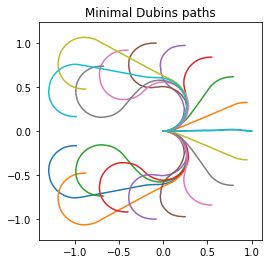

In [8]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal Dubins paths'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 
savefig(fig,'Paths_NoDrift.png')

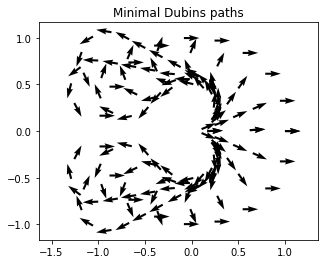

In [9]:
fig=plt.figure(figsize=[5,4]); plt.title('Minimal Dubins paths'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  quiver(geo[0],geo[1],np.cos(geo[2]),np.sin(geo[2]),subsampling=(50,))
savefig(fig,'Directions_NoDrift.png')

## 2. Adding a constant drift

We add a drift which pushes the boat in a constant direction.
The total boat velocity, with respect to the ground absolute referential, is the sum 
$$
    V_\mathrm{tot} = (v_0 + \cos(\theta), v_1 + \sin (\theta))
$$
of the relative velocity $(\cos(\theta),\sin(\theta))$ and of the drift $v=(v_0,v_1)$.

In [10]:
X,Y,Theta = hfmIn.Grid()

In [11]:
drift = xp.array([0.3,0.4])
velocity = ad.asarray([drift[0]+np.cos(Theta), drift[1]+np.sin(Theta)])

Note the anisotropy introduced in the model: the vehicle moves at speed $1+\|v\|$ when pushed by the drift, and at speed $1-\|v\|$ in the opposite direction. 

Our implementation of the Dubins model involves a relaxation parameter $\epsilon$, which should remain substantially smaller than the $\min/\max$ speed ratio, elsewise numerical diffusion may corrupt the results. By default $\epsilon = 0.1$. (When reducing $\epsilon$, the number of orientations for the angular domain discretization should be increased.)

In [12]:
print('Min/Max speed ratio : ', (1-np.linalg.norm(drift))/(1+np.linalg.norm(drift)))

Min/Max speed ratio :  0.3333333333333333


The total velocity $V_\mathrm{tot}$ is provided to the HFM library, in polar form.

In [13]:
hfmIn.update({
    'speed':np.linalg.norm(velocity,axis=0), # total velocity norm
    'theta':np.arctan2(velocity[1],velocity[0]), # total velocity orientation
})
hfmIn['xi'] = xi * hfmIn['speed'] # Needed to enforce the curvature bound constraint in the moving frame

Let us give a sketch of justification for the above expression.
The metric of the standard Dubins model reads,
$$
    F_{(x,n)}(\dot x,\dot n) = \|\dot x\| \qquad 
    \text{if } \dot x \propto n  \text{ and } \xi \|\dot n\| \leq \|\dot x\|,
$$
and $F_{(x,n)}(\dot x,\dot n) = \infty$ otherwise. By $\dot x \propto n$ we mean that the physical velocity $\dot x$ is positively proportional to the vehicle orientation $n$.

The modified variant, featuring a drift and referred to as the Zermelo-Dubins model, reads
$$
    {\mathbf F}_{(x,n)}(\dot {\mathbf x},\dot n) = \|\dot {\mathbf x}\|/\|V_\mathrm{tot}\| \qquad 
    \text{if } \dot {\mathbf x} \propto V_\mathrm{tot}  \text{ and } \xi \|V_\mathrm{tot}\| \|\dot n\| \leq \|\dot {\mathbf x}\|.
$$
The three occurences of $V_\mathrm{tot}$ in this expression correspond to the three modified parameters in the model.

Finally, we note that the two metrics $F$ and $\mathbf F$ are designed so that 
$$
    F_{(x,n)}(\dot x,\dot n) = {\mathbf F}_{(x,n)}(\dot {\mathbf x},\dot n) \qquad \text{if } \dot x = n \text{ and } \dot {\mathbf x} = V_\mathrm{tot}.
$$

In [14]:
if hfmIn.mode=='gpu':hfmIn['geodesic_targetTolerance']=25 # TODO : improve GPU geodesic stopping criterion

In [15]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 8.50042 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


Among the optimal trajectories, illustrated below, we see two distinct types of turns:
* Turns with the wind in the back, which are very large. <!---E.g. turning left at the seed point.-->
* Turns against the wind, which are contracted. <!---E.g. turning right at the seed point.-->

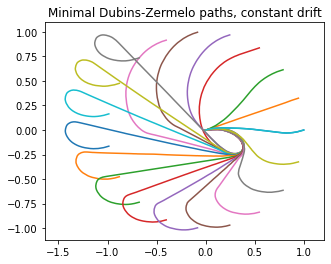

In [16]:
fig=plt.figure(figsize=[5,4]); plt.title('Minimal Dubins-Zermelo paths, constant drift'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 
savefig(fig,'Paths_ConstantDrift.png')

The orientation of the vehicle $n$, is not aligned with the physical velocity $\dot x$ in the absolute frame of reference, in which the vehicle moves forward like a crab.

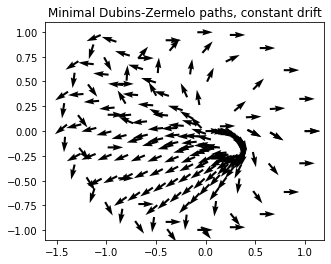

In [17]:
fig=plt.figure(figsize=[5,4]); plt.title('Minimal Dubins-Zermelo paths, constant drift'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  quiver(geo[0],geo[1],np.cos(geo[2]),np.sin(geo[2]),subsampling=(50,))
savefig(fig,'Directions_ConstantDrift.png')

In order to check the model, we display the trajectories in the vehicle referential, offset by the total drift:
$$
    \gamma(t) - t v.
$$
By construction, these trajectories are minimal paths between their endpoints for the standard Dubins model.

For that purpose, we need to know the time parametrization of the minimal path $\gamma$. This is achieved by interpolating the value function.

In [18]:
aX,aY,aTheta = hfmIn.Axes()
aTheta = np.concatenate([aTheta-2.*np.pi,aTheta,aTheta+2*np.pi])

In [19]:
TravelTime = UniformGridInterpolation( (aX,aY,aTheta),  np.tile(hfmOut['values'],(1,1,3)))

Note that the value function is discontinuous at the seed point, since the Dubins-Zermelo model is not locally controllable. For this reason, we will avoid interpolation too close to the seed point, at the end of the geodesic (which is backtracked from the tip to the seed).

In the moving frame, the optimal trajectories are concatenations straight lines and circle arcs, as illustrated below (up to numerical imprecisions).

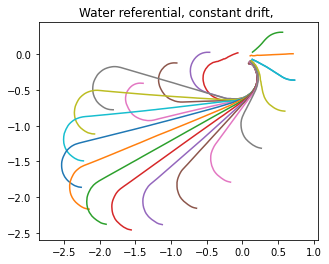

In [20]:
fig=plt.figure(figsize=[5,4]); plt.title("Water referential, constant drift, "); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  
    geo = geo[:,:-20] # Exclude the last points of the geodesic, close to the seed point.
    geo[2]=np.mod(geo[2],2*np.pi)
    time = TravelTime(geo)
    plt.plot(*(geo[:2]-time*drift.reshape(2,1))) 
savefig(fig,'PathsInWater_ConstantDrift.png')

<!---In principle, the previous trajectories should be concatenations of straight lines and round circles, as in Dubin's standard model. This is only approximately the case, due to the small parameter $\epsilon$ introduced to relax and implement Dubins' model. In order to get more accuracy, we can decrease $\epsilon$ and increase the resolution.

Maurizio Falcone
-->

The orientation $\theta$ of the vehicle, the third component of the geodesic, is aligned with the the trajectory in the moving frame, which follows the drift (illustration below). 

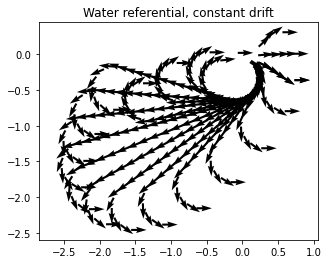

In [21]:
fig=plt.figure(figsize=[5,4]); plt.title("Water referential, constant drift"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  
    geo = geo[:,:-20] # Exclude the last points of the geodesic, close to the seed point.
    geo[2]=np.mod(geo[2],2*np.pi)
    time = TravelTime(geo)
    quiver(*(geo[:2]-time*drift.reshape(2,1)), np.cos(geo[2]),np.sin(geo[2]),subsampling=(30,))
savefig(fig,'DirectionsInWater_ConstantDrift.png')

### 2.1 Consistency test : unoriented seeds and tips.

In order to validate the consistency of the discretization, we consider the case where the vehicle orientation at the seeds and tips is arbitrary. 

In [22]:
hfmIn.update({
    'seed_Unoriented':[0,0],
    'tips_Unoriented':[(np.cos(t),np.sin(t)) for t in np.linspace(0,2*np.pi,20)] 
})

In [23]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 8.98788 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In that case, the optimal trajectory is to go in a straight line, from seed to tip. 
<!---This is what we observe, despite some amount of numerical diffusion for paths going almost straight against the drift, in the bottom left corner.-->

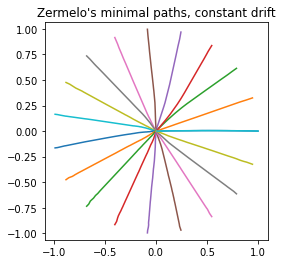

In [24]:
fig=plt.figure(figsize=[4,4]); plt.title("Zermelo's minimal paths, constant drift"); plt.axis('equal'); 
for geo in hfmOut['geodesics_Unoriented']:  plt.plot(geo[0],geo[1]) 
savefig(fig,'Paths_UnorientedConstantDrift.png')

Note that the boat orientation is not aligned with its trajectory. Instead, the boat moves 'like a crab', sideways, maintaining a constant angle with the drift.

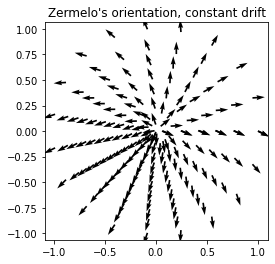

In [25]:
fig=plt.figure(figsize=[4,4]); plt.title("Zermelo's orientation, constant drift"); plt.axis('equal'); 
for geo in hfmOut['geodesics_Unoriented']: 
    quiver(geo[0],geo[1],np.cos(geo[2]),np.sin(geo[2]),subsampling=(30,)) 
savefig(fig,'Directions_UnorientedConstantDrift.png')

The reachable set, in a given time $t$, is the disk of radius $t$ offset by the drift distance. (With arbitrary seed and tip orientation.)

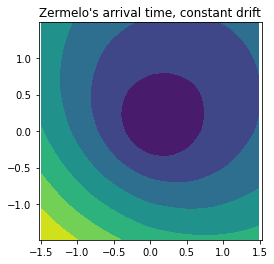

In [26]:
fig=plt.figure(figsize=[4,4]); plt.title("Zermelo's arrival time, constant drift"); plt.axis('equal')
plt.contourf(X[:,:,0],Y[:,:,0],np.min(hfmOut['values'],axis=2));
savefig(fig,'Times_UnorientedConstantDrift.png')

In [27]:
hfmIn.pop('seed_Unoriented',None);

## 3. Non-constant drift

The drift imposed on the vehicle may depend on both its position $x$ and orientation $n$. However, for illustration purposes, we limit our attention to two examples where it only depends either:
* On the physical position $x$, as in the classical model of Zermelo.
* On the orientation $n$, which may model aerodynamical effects.

### 3.1 Position dependent drift

We consider a drift depending only on the physical position. Note that a similar example is presented in [A.III - Rander metrics. Application to Zermelo's navigation problem, and image segmentation](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A6_Rander.ipynb), but without the constraint on the radius of curvature.

In [28]:
R = np.sqrt(X**2+Y**2)
driftMult = 0.6*np.sin(np.pi*X)*np.sin(np.pi*Y)
driftX,driftY = driftMult*X/R, driftMult*Y/R

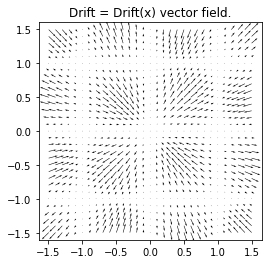

In [29]:
fig=plt.figure(figsize=[4,4]); plt.title("Drift = Drift(x) vector field."); plt.axis('equal')
quiver(X[:,:,0],Y[:,:,0], driftX[:,:,0], driftY[:,:,0],subsampling=(5,5));
savefig(fig,'PositionDrift.png')

In [30]:
velocity = ad.array([driftX+np.cos(Theta), driftY+np.sin(Theta)])

In [31]:
hfmIn.update({
    'speed':np.linalg.norm(velocity,axis=0), # total velocity norm
    'theta':np.arctan2(velocity[1],velocity[0]), # total velocity orientation
})
hfmIn['xi'] = xi * hfmIn['speed']

In [32]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 9.87305 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


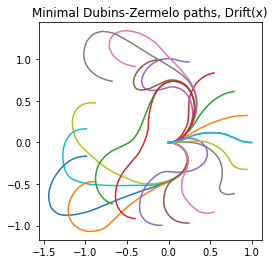

In [33]:
fig=plt.figure(figsize=[4,4]); plt.title('Minimal Dubins-Zermelo paths, Drift(x)'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 
savefig(fig,'Paths_PositionDrift.png')

In [34]:
time_I = UniformGridInterpolation( (aX,aY,aTheta), np.tile(hfmOut['values'],(1,1,3)))
driftX_I = UniformGridInterpolation( (aX,aY), driftX[:,:,0])
driftY_I = UniformGridInterpolation( (aX,aY), driftY[:,:,0])

In the moving frame of reference, the radius of curvature obeys the prescribed bound.

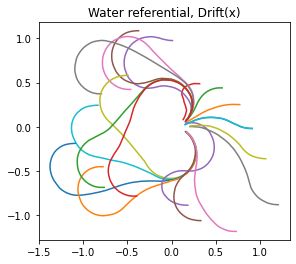

In [35]:
fig=plt.figure(figsize=[4.5,4]); plt.title("Water referential, Drift(x)"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  
    geo = np.flip(geo[:,:-20],axis=1) # Exclude the last points of the geodesic, close to the seed point.
    geo[2]=np.mod(geo[2],2*np.pi)
    time_G = time_I(geo)
    timesteps = np.concatenate((time_G[:1],np.diff(time_G)))
    driftX_G = driftX_I(geo[:2])
    driftY_G = driftY_I(geo[:2])
    plt.plot(geo[0]-np.cumsum(timesteps*driftX_G), geo[1]-np.cumsum(timesteps*driftY_G)) 

<!--- Note however that one trajectory, at the bottom in purple, seems to violate the imposed bound on curvature bound substantially. 
This is due to numerical diffusion, because the $\min/\max$ speed ratio is too close to $\epsilon$.
The current remedy is to decrease the relaxation parameter $\epsilon$, the angular scale and the physical scale, at the expense of computation time. See notebook [B.I - Curvature penalized planar paths](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A4_Curvature.ipynb) for illustration, where a similar phenomenon arises due to the presence of obstacles. The development of more accurate numerical schemes will be the object of future research.
-->

### 3.2 Orientation dependent drift

We consider a boat whose drift is dependent on the orientation. This may arise in practice if the drift due to the wind, which is weaker when the boat faces the wind, and stronger when it is orthogonal to the wind.
Note that a related problem, modeling a sailboat and involving the Reeds-Shepp forward model, is presented in [B.I - Curvature penalized planar paths](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A4_Curvature.ipynb).

The drift, velocity, and various input fields only depend on the orientation, through the variable $\theta$. Thus we do not need a full $X,Y,\Theta$ grid.

In [36]:
Theta2 = Theta[0,0]

In [37]:
driftX = 0.1*np.cos(Theta2)**2+0.5*np.sin(Theta2)**2
driftY = 0.4*driftX

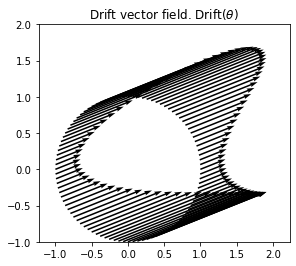

In [38]:
fig=plt.figure(figsize=[4.5,4]); plt.title(r"Drift vector field. Drift($\theta$)"); plt.axis('equal'); plt.xlim(-2,3); plt.ylim(-1,2);
plt.quiver(np.cos(Theta2),np.sin(Theta2),  driftX,driftY,scale=1);
savefig(fig,'OrientationDrift.png')

In [39]:
velocity = ad.array([driftX+np.cos(Theta2), driftY+np.sin(Theta2)])

In [40]:
hfmIn.update({
    'speed':np.linalg.norm(velocity,axis=0), # total velocity norm
    'theta':np.arctan2(velocity[1],velocity[0]), # total velocity orientation
})
hfmIn['xi'] = xi * hfmIn['speed']

In [41]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 8.68111 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


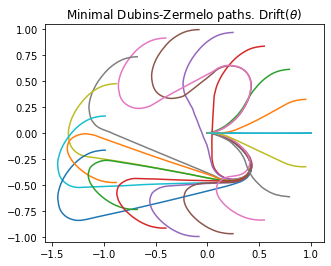

In [42]:
fig=plt.figure(figsize=[5,4]); plt.title(r"Minimal Dubins-Zermelo paths. Drift($\theta$)"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 
savefig(fig,'Paths_OrientationDrift.png')

As before, the vehicle obeys the Dubins' model hard constraint on the radius of curvature in its frame of reference.

In [43]:
time_I =   UniformGridInterpolation( (aX,aY,aTheta), np.tile(hfmOut['values'],(1,1,3)))
driftX_I = UniformGridInterpolation( (aTheta,), np.tile(driftX,3))
driftY_I = UniformGridInterpolation( (aTheta,), np.tile(driftY,3))

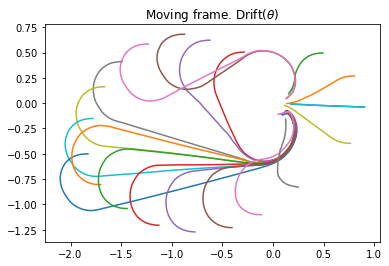

In [44]:
fig=plt.figure(figsize=[6,4]); plt.axis('equal'); plt.title(r"Moving frame. Drift($\theta$)");
for geo in hfmOut['geodesics']:  
    geo = np.flip(geo[:,:-20],axis=1) # Exclude the last points of the geodesic, close to the seed point.
    geo[2]=np.mod(geo[2],2*np.pi)
    time_G = time_I(geo)
    timesteps = np.concatenate((time_G[:1],np.diff(time_G)))
    driftX_G = driftX_I(geo[2:])
    driftY_G = driftY_I(geo[2:])
    plt.plot(geo[0]-np.cumsum(timesteps*driftX_G), geo[1]-np.cumsum(timesteps*driftY_G)) 
savefig(fig,'PathsInWater_OrientationDrift.png')